In [ ]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature

In [ ]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["color"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [ ]:
def plurality_plot_x(df):
    projPC = crs.PlateCarree()
    latN = df["lat_x"].max() + 1
    latS = df["lat_x"].min() - 1
    lonW = df["lon_x"].max() + 1
    lonE = df["lon_x"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon_x"],
        y=df["lat_x"],
        c=df["color"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [ ]:
# get lons and lats
# This will return the most recent data avail on mesonet
# this is my file path
ny_mesonet_data_path = "/home/aevans/nysm/archive/nysm/netcdf/proc/"
ok_mesonet_data_path = "/home/aevans/landtype/geoinfo.csv"

In [ ]:
# create a dataframe of mesonet data ny
ny_df = most_recent_mesonet_data.current_time_mesonet_df(ny_mesonet_data_path)
ny_df = most_recent_mesonet_time.most_recent_time(ny_df, ny_mesonet_data_path)

In [ ]:
ny_df_lons = ny_df["lon"].to_list()
ny_df_lats = ny_df["lat"].to_list()

In [ ]:
df_lulc = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/buffer_10_percent.csv")
df_lulc.head()

In [ ]:
# exclude the categorical columns
features = df_lulc.drop(["site", "station"], axis=1)

In [ ]:
features.describe()

In [ ]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(features)

In [ ]:
pd.DataFrame(features_normal).describe()

In [ ]:
# kmeans clustering
inertia = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)

In [ ]:
# Plot the elbow
plt.plot(K, inertia, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# let's say our elbow is 12
kmeans = KMeans(n_clusters=6).fit(features_normal)

In [ ]:
labels = pd.DataFrame(
    kmeans.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledClasses = pd.concat((features, labels), axis=1)
labeledClasses = labeledClasses.rename({0: "labels"}, axis=1)

In [ ]:
labeledClasses.head()

In [ ]:
sns.pairplot(labeledClasses, hue="labels")

In [ ]:
labeledClasses[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [ ]:
f, axes = plt.subplots(
    4, 5, figsize=(20, 25), sharex=False
)  # create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7)  # Scooch em apart, give em some room
# In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
for i in range(
    0, len(list(labeledClasses)) - 2
):  # minus two because I don't want to plot labels or constant
    col = labeledClasses.columns[i]
    if i < 5:
        ax = sns.stripplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            jitter=True,
            ax=axes[0, (i)],
        )
        ax.set_title(col)
    elif i >= 5 and i < 10:
        ax = sns.stripplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            jitter=True,
            ax=axes[1, (i - 5)],
        )  # so if i=6 it is row 1 column 1
        ax.set_title(col)
    elif i >= 10 and i < 15:
        ax = sns.stripplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            jitter=True,
            ax=axes[2, (i - 10)],
        )
        ax.set_title(col)
    elif i >= 15:
        ax = sns.stripplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            jitter=True,
            ax=axes[3, (i - 15)],
        )
        ax.set_title(col)

In [ ]:
f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in range(0, len(list(labeledClasses)) - 2):
    col = labeledClasses.columns[i]
    if i < 5:
        ax = sns.swarmplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            ax=axes[0, (i)],
        )
        ax.set_title(col)
    elif i >= 5 and i < 10:
        ax = sns.swarmplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            ax=axes[1, (i - 5)],
        )
        ax.set_title(col)
    elif i >= 10 and i < 15:
        ax = sns.swarmplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            ax=axes[2, (i - 10)],
        )
        ax.set_title(col)
    elif i >= 15:
        ax = sns.swarmplot(
            x=labeledClasses["Constant"],
            y=labeledClasses[col].values,
            hue=labeledClasses["labels"],
            ax=axes[3, (i - 15)],
        )
        ax.set_title(col)

In [ ]:
classes = df_lulc["station"]
classes = pd.concat((classes, labels), axis=1)
classes = classes.rename({"station": "station", 0: "Cluster"}, axis=1)
sortclasses = classes.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortclasses["lon"] = ny_df_lons
sortclasses["lat"] = ny_df_lats

In [ ]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortclasses["color"] = sortclasses["Cluster"].map(colordict)

In [ ]:
plurality_plot(sortclasses)

# Let's cluster on Elevation

In [ ]:
elev_df = pd.read_csv(
    "/home/aevans/nwp_bias/src/landtype/elevation/data/NY/elev/ny30_df.csv"
)
elev_df.head()

In [ ]:
# exclude the categorical columns
features_elev = elev_df.drop(["station", "Unnamed: 0", "lon", "lat"], axis=1)

In [ ]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_norm = scaler.fit_transform(features_elev)

In [ ]:
pd.DataFrame(features_norm).describe()

In [ ]:
# kmeans clustering
inertia_elev = []
K = range(1, 15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_norm)
    kmeanModel.fit(features_norm)
    inertia_elev.append(kmeanModel.inertia_)

In [ ]:
# Plot the elbow
plt.plot(K, inertia_elev, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# let's say our elbow is 12
kmeans_elev = KMeans(n_clusters=6).fit(features_norm)

In [ ]:
labels_elev = pd.DataFrame(
    kmeans_elev.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledElev = pd.concat((features_elev, labels_elev), axis=1)
labeledElev = labeledElev.rename({0: "labels"}, axis=1)

In [ ]:
labeledElev.head()

In [ ]:
sns.pairplot(labeledElev, hue="labels")

In [ ]:
labeledElev[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [ ]:
f, axes = plt.subplots(
    4, 5, figsize=(20, 25), sharex=False
)  # create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7)  # Scooch em apart, give em some room
# In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
for i in range(
    0, len(list(labeledElev)) - 2
):  # minus two because I don't want to plot labels or constant
    col = labeledElev.columns[i]
    if i < 5:
        ax = sns.stripplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            jitter=True,
            ax=axes[0, (i)],
        )
        ax.set_title(col)
    elif i >= 5 and i < 10:
        ax = sns.stripplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            jitter=True,
            ax=axes[1, (i - 5)],
        )  # so if i=6 it is row 1 column 1
        ax.set_title(col)
    elif i >= 10 and i < 15:
        ax = sns.stripplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            jitter=True,
            ax=axes[2, (i - 10)],
        )
        ax.set_title(col)
    elif i >= 15:
        ax = sns.stripplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            jitter=True,
            ax=axes[3, (i - 15)],
        )
        ax.set_title(col)

In [ ]:
f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in range(0, len(list(labeledElev)) - 2):
    col = labeledElev.columns[i]
    if i < 5:
        ax = sns.swarmplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            ax=axes[0, (i)],
        )
        ax.set_title(col)
    elif i >= 5 and i < 10:
        ax = sns.swarmplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            ax=axes[1, (i - 5)],
        )
        ax.set_title(col)
    elif i >= 10 and i < 15:
        ax = sns.swarmplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            ax=axes[2, (i - 10)],
        )
        ax.set_title(col)
    elif i >= 15:
        ax = sns.swarmplot(
            x=labeledElev["Constant"],
            y=labeledElev[col].values,
            hue=labeledElev["labels"],
            ax=axes[3, (i - 15)],
        )
        ax.set_title(col)

In [ ]:
elevs = df_lulc["station"]
elevs = pd.concat((elevs, labels_elev), axis=1)
elevs = elevs.rename({"station": "station", 0: "Cluster"}, axis=1)
sortelevs = elevs.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortelevs["lon"] = ny_df_lons
sortelevs["lat"] = ny_df_lats

In [ ]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortelevs["color"] = sortelevs["Cluster"].map(colordict)

In [ ]:
plurality_plot(sortelevs)

# let's cluster on slope

In [ ]:
slope_df = pd.read_csv(
    "/home/aevans/nwp_bias/src/landtype/elevation/data/NY/slope/sl_percent_30.csv"
)
slope_df.head()

In [ ]:
# exclude the categorical columns
features_slope = slope_df.drop(["site", "station"], axis=1)

In [ ]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_norm_sl = scaler.fit_transform(features_slope)

In [ ]:
pd.DataFrame(features_norm_sl).describe()

In [ ]:
# kmeans clustering
inertia_slope = []
K = range(1, 15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_norm_sl)
    kmeanModel.fit(features_norm_sl)
    inertia_slope.append(kmeanModel.inertia_)

In [ ]:
# Plot the elbow
plt.plot(K, inertia_slope, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# let's say our elbow is 12
kmeans_slope = KMeans(n_clusters=6).fit(features_norm_sl)

In [ ]:
labels_slope = pd.DataFrame(
    kmeans_slope.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledSlope = pd.concat((features_slope, labels_slope), axis=1)
labeledSlope = labeledSlope.rename({0: "labels"}, axis=1)

In [ ]:
labeledSlope.head()

In [ ]:
sns.pairplot(labeledSlope, hue="labels")

In [ ]:
labeledSlope[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [ ]:
f, axes = plt.subplots(
    4, 5, figsize=(20, 25), sharex=False
)  # create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7)  # Scooch em apart, give em some room
# In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
for i in range(
    0, len(list(labeledSlope)) - 2
):  # minus two because I don't want to plot labels or constant
    col = labeledSlope.columns[i]
    if i < 5:
        ax = sns.stripplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            jitter=True,
            ax=axes[0, (i)],
        )
        ax.set_title(col)
    elif i >= 5 and i < 10:
        ax = sns.stripplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            jitter=True,
            ax=axes[1, (i - 5)],
        )  # so if i=6 it is row 1 column 1
        ax.set_title(col)
    elif i >= 10 and i < 15:
        ax = sns.stripplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            jitter=True,
            ax=axes[2, (i - 10)],
        )
        ax.set_title(col)
    elif i >= 15:
        ax = sns.stripplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            jitter=True,
            ax=axes[3, (i - 15)],
        )
        ax.set_title(col)

In [ ]:
f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in range(0, len(list(labeledSlope)) - 2):
    col = labeledSlope.columns[i]
    if i < 5:
        ax = sns.swarmplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            ax=axes[0, (i)],
        )
        ax.set_title(col)
    elif i >= 5 and i < 10:
        ax = sns.swarmplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            ax=axes[1, (i - 5)],
        )
        ax.set_title(col)
    elif i >= 10 and i < 15:
        ax = sns.swarmplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            ax=axes[2, (i - 10)],
        )
        ax.set_title(col)
    elif i >= 15:
        ax = sns.swarmplot(
            x=labeledSlope["Constant"],
            y=labeledSlope[col].values,
            hue=labeledSlope["labels"],
            ax=axes[3, (i - 15)],
        )
        ax.set_title(col)

In [ ]:
slopes = df_lulc["station"]
slopes = pd.concat((slopes, labels_slope), axis=1)
slopes = slopes.rename({"station": "station", 0: "Cluster"}, axis=1)
sortslopes = slopes.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortslopes["lon"] = ny_df_lons
sortslopes["lat"] = ny_df_lats

In [ ]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortslopes["color"] = sortslopes["Cluster"].map(colordict)

In [ ]:
plurality_plot(sortslopes)
plurality_plot(sortclasses)
plurality_plot(sortelevs)

# Let's cluster on all vars

In [ ]:
comb = pd.merge(df_lulc, elev_df, on="station")
comb.head()

In [123]:
comb_df = pd.merge(comb, slope_df, on="station")

In [124]:
comb_df.head()

,site_x,11,21_x,22_x,23_x,24_x,31_x,41,42,43,...,27,28,33,37,32,34,38,31_y,35,36
0,1,1.962930,5.647257,1.299929,0.483068,0.109736,0.137242,29.370894,3.830164,25.780258,...,2.558480,3.070175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.820203,4.007140,0.595656,0.093976,0.009168,0.090537,66.349595,2.819553,11.070490,...,6.695005,7.970244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.697071,5.277453,4.213367,2.021878,0.932866,0.281350,7.929932,0.161303,1.428809,...,0.438276,0.255661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,10.653124,11.111843,10.012464,9.876366,3.972609,0.532928,42.712777,0.089967,0.535507,...,3.123878,2.046679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.649265,4.491848,1.082204,0.356723,0.039254,0.121773,28.382281,6.408126,31.918283,...,3.708937,3.355705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
features_all = comb_df.drop(
    ["site_x", "station", "variance", "Unnamed: 0", "lon", "lat", "site_y"], axis=1
)
features_all.head()

,11,21_x,22_x,23_x,24_x,31_x,41,42,43,52,...,27,28,33,37,32,34,38,31_y,35,36
0,1.962930,5.647257,1.299929,0.483068,0.109736,0.137242,29.370894,3.830164,25.780258,0.441523,...,2.558480,3.070175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.820203,4.007140,0.595656,0.093976,0.009168,0.090537,66.349595,2.819553,11.070490,0.875577,...,6.695005,7.970244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.697071,5.277453,4.213367,2.021878,0.932866,0.281350,7.929932,0.161303,1.428809,0.209436,...,0.438276,0.255661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.653124,11.111843,10.012464,9.876366,3.972609,0.532928,42.712777,0.089967,0.535507,0.405427,...,3.123878,2.046679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.649265,4.491848,1.082204,0.356723,0.039254,0.121773,28.382281,6.408126,31.918283,0.320048,...,3.708937,3.355705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
features_all.keys()

Index(['11', '21_x', '22_x', '23_x', '24_x', '31_x', '41', '42', '43', '52',
       '71', '81', '82', '90', '95', 'elev', 'std', 'skew', 'med_dist', '19',
       '21_y', '22_y', '23_y', '24_y', '25', '26', '27', '28', '33', '37',
       '32', '34', '38', '31_y', '35', '36'],
      dtype='object')

In [127]:
# features_all.to_csv("/home/aevans/landtype/notebooks/features.csv")

In [128]:
features_all.head()

,11,21_x,22_x,23_x,24_x,31_x,41,42,43,52,...,27,28,33,37,32,34,38,31_y,35,36
0,1.962930,5.647257,1.299929,0.483068,0.109736,0.137242,29.370894,3.830164,25.780258,0.441523,...,2.558480,3.070175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.820203,4.007140,0.595656,0.093976,0.009168,0.090537,66.349595,2.819553,11.070490,0.875577,...,6.695005,7.970244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.697071,5.277453,4.213367,2.021878,0.932866,0.281350,7.929932,0.161303,1.428809,0.209436,...,0.438276,0.255661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.653124,11.111843,10.012464,9.876366,3.972609,0.532928,42.712777,0.089967,0.535507,0.405427,...,3.123878,2.046679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.649265,4.491848,1.082204,0.356723,0.039254,0.121773,28.382281,6.408126,31.918283,0.320048,...,3.708937,3.355705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_norm_a = scaler.fit_transform(features_all)

In [130]:
# kmeans clustering
inertia_elev = []
K = range(1, 40)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_norm_a)
    kmeanModel.fit(features_norm_a)
    inertia_elev.append(kmeanModel.inertia_)

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

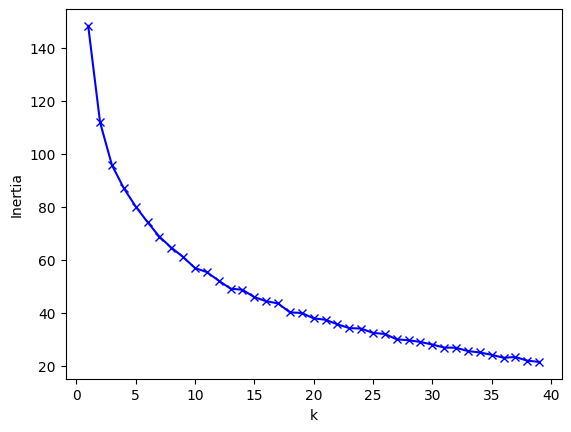

In [131]:
# Plot the elbow
plt.plot(K, inertia_elev, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [158]:
# let's say our elbow is 12
kmeans_all = KMeans(n_clusters=8).fit(features_norm_a)

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [159]:
features_all.head()

,11,21_x,22_x,23_x,24_x,31_x,41,42,43,52,...,27,28,33,37,32,34,38,31_y,35,36
0,1.962930,5.647257,1.299929,0.483068,0.109736,0.137242,29.370894,3.830164,25.780258,0.441523,...,2.558480,3.070175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.820203,4.007140,0.595656,0.093976,0.009168,0.090537,66.349595,2.819553,11.070490,0.875577,...,6.695005,7.970244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.697071,5.277453,4.213367,2.021878,0.932866,0.281350,7.929932,0.161303,1.428809,0.209436,...,0.438276,0.255661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.653124,11.111843,10.012464,9.876366,3.972609,0.532928,42.712777,0.089967,0.535507,0.405427,...,3.123878,2.046679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.649265,4.491848,1.082204,0.356723,0.039254,0.121773,28.382281,6.408126,31.918283,0.320048,...,3.708937,3.355705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
labels_a = pd.DataFrame(
    kmeans_all.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledAll = pd.concat((features_all, labels_a), axis=1)
labeledAll = labeledAll.rename({0: "labels"}, axis=1)

In [161]:
labeledAll.head()

,11,21_x,22_x,23_x,24_x,31_x,41,42,43,52,...,28,33,37,32,34,38,31_y,35,36,labels
0,1.962930,5.647257,1.299929,0.483068,0.109736,0.137242,29.370894,3.830164,25.780258,0.441523,...,3.070175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.820203,4.007140,0.595656,0.093976,0.009168,0.090537,66.349595,2.819553,11.070490,0.875577,...,7.970244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,0.697071,5.277453,4.213367,2.021878,0.932866,0.281350,7.929932,0.161303,1.428809,0.209436,...,0.255661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,10.653124,11.111843,10.012464,9.876366,3.972609,0.532928,42.712777,0.089967,0.535507,0.405427,...,2.046679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,0.649265,4.491848,1.082204,0.356723,0.039254,0.121773,28.382281,6.408126,31.918283,0.320048,...,3.355705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [162]:
# sns.pairplot(labeledAll,hue='labels')

In [163]:
labeledAll[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [164]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
# f.subplots_adjust(hspace=0.2, wspace=0.7) #Scooch em apart, give em some room
# #In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
# for i in range(0,len(list(labeledAll))-2): #minus two because I don't want to plot labels or constant
#     col = labeledAll.columns[i]
#     if i < 5:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[0,(i)])
#         ax.set_title(col)
#     elif i >= 5 and i<10:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[1,(i-5)]) #so if i=6 it is row 1 column 1
#         ax.set_title(col)
#     elif i >= 10 and i<15:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[2,(i-10)])
#         ax.set_title(col)
#     elif i >= 15 and i<20:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[3,(i-15)])
#         ax.set_title(col)
#     elif i >= 20:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[4,(i-20)])
#         ax.set_title(col)

In [165]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
# f.subplots_adjust(hspace=0.2, wspace=0.7)
# for i in range(0,len(list(labeledAll))-2):
#     col = labeledAll.columns[i]
#     if i < 5:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[0,(i)])
#         ax.set_title(col)
#     elif i >= 5 and i<10:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[1,(i-5)])
#         ax.set_title(col)
#     elif i >= 10 and i<15:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[2,(i-10)])
#         ax.set_title(col)
#     elif i >= 15 and i <20:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[3,(i-15)])
#         ax.set_title(col)
#     elif i >= 20:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[3,(i-20)])
#         ax.set_title(col)

In [166]:
alls = df_lulc["station"]
alls = pd.concat((alls, labels_a), axis=1)
alls = alls.rename({"station": "station", 0: "Cluster"}, axis=1)
sortAll = alls.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortAll["lon"] = ny_df_lons
sortAll["lat"] = ny_df_lats

In [167]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortAll["color"] = sortAll["Cluster"].map(colordict)

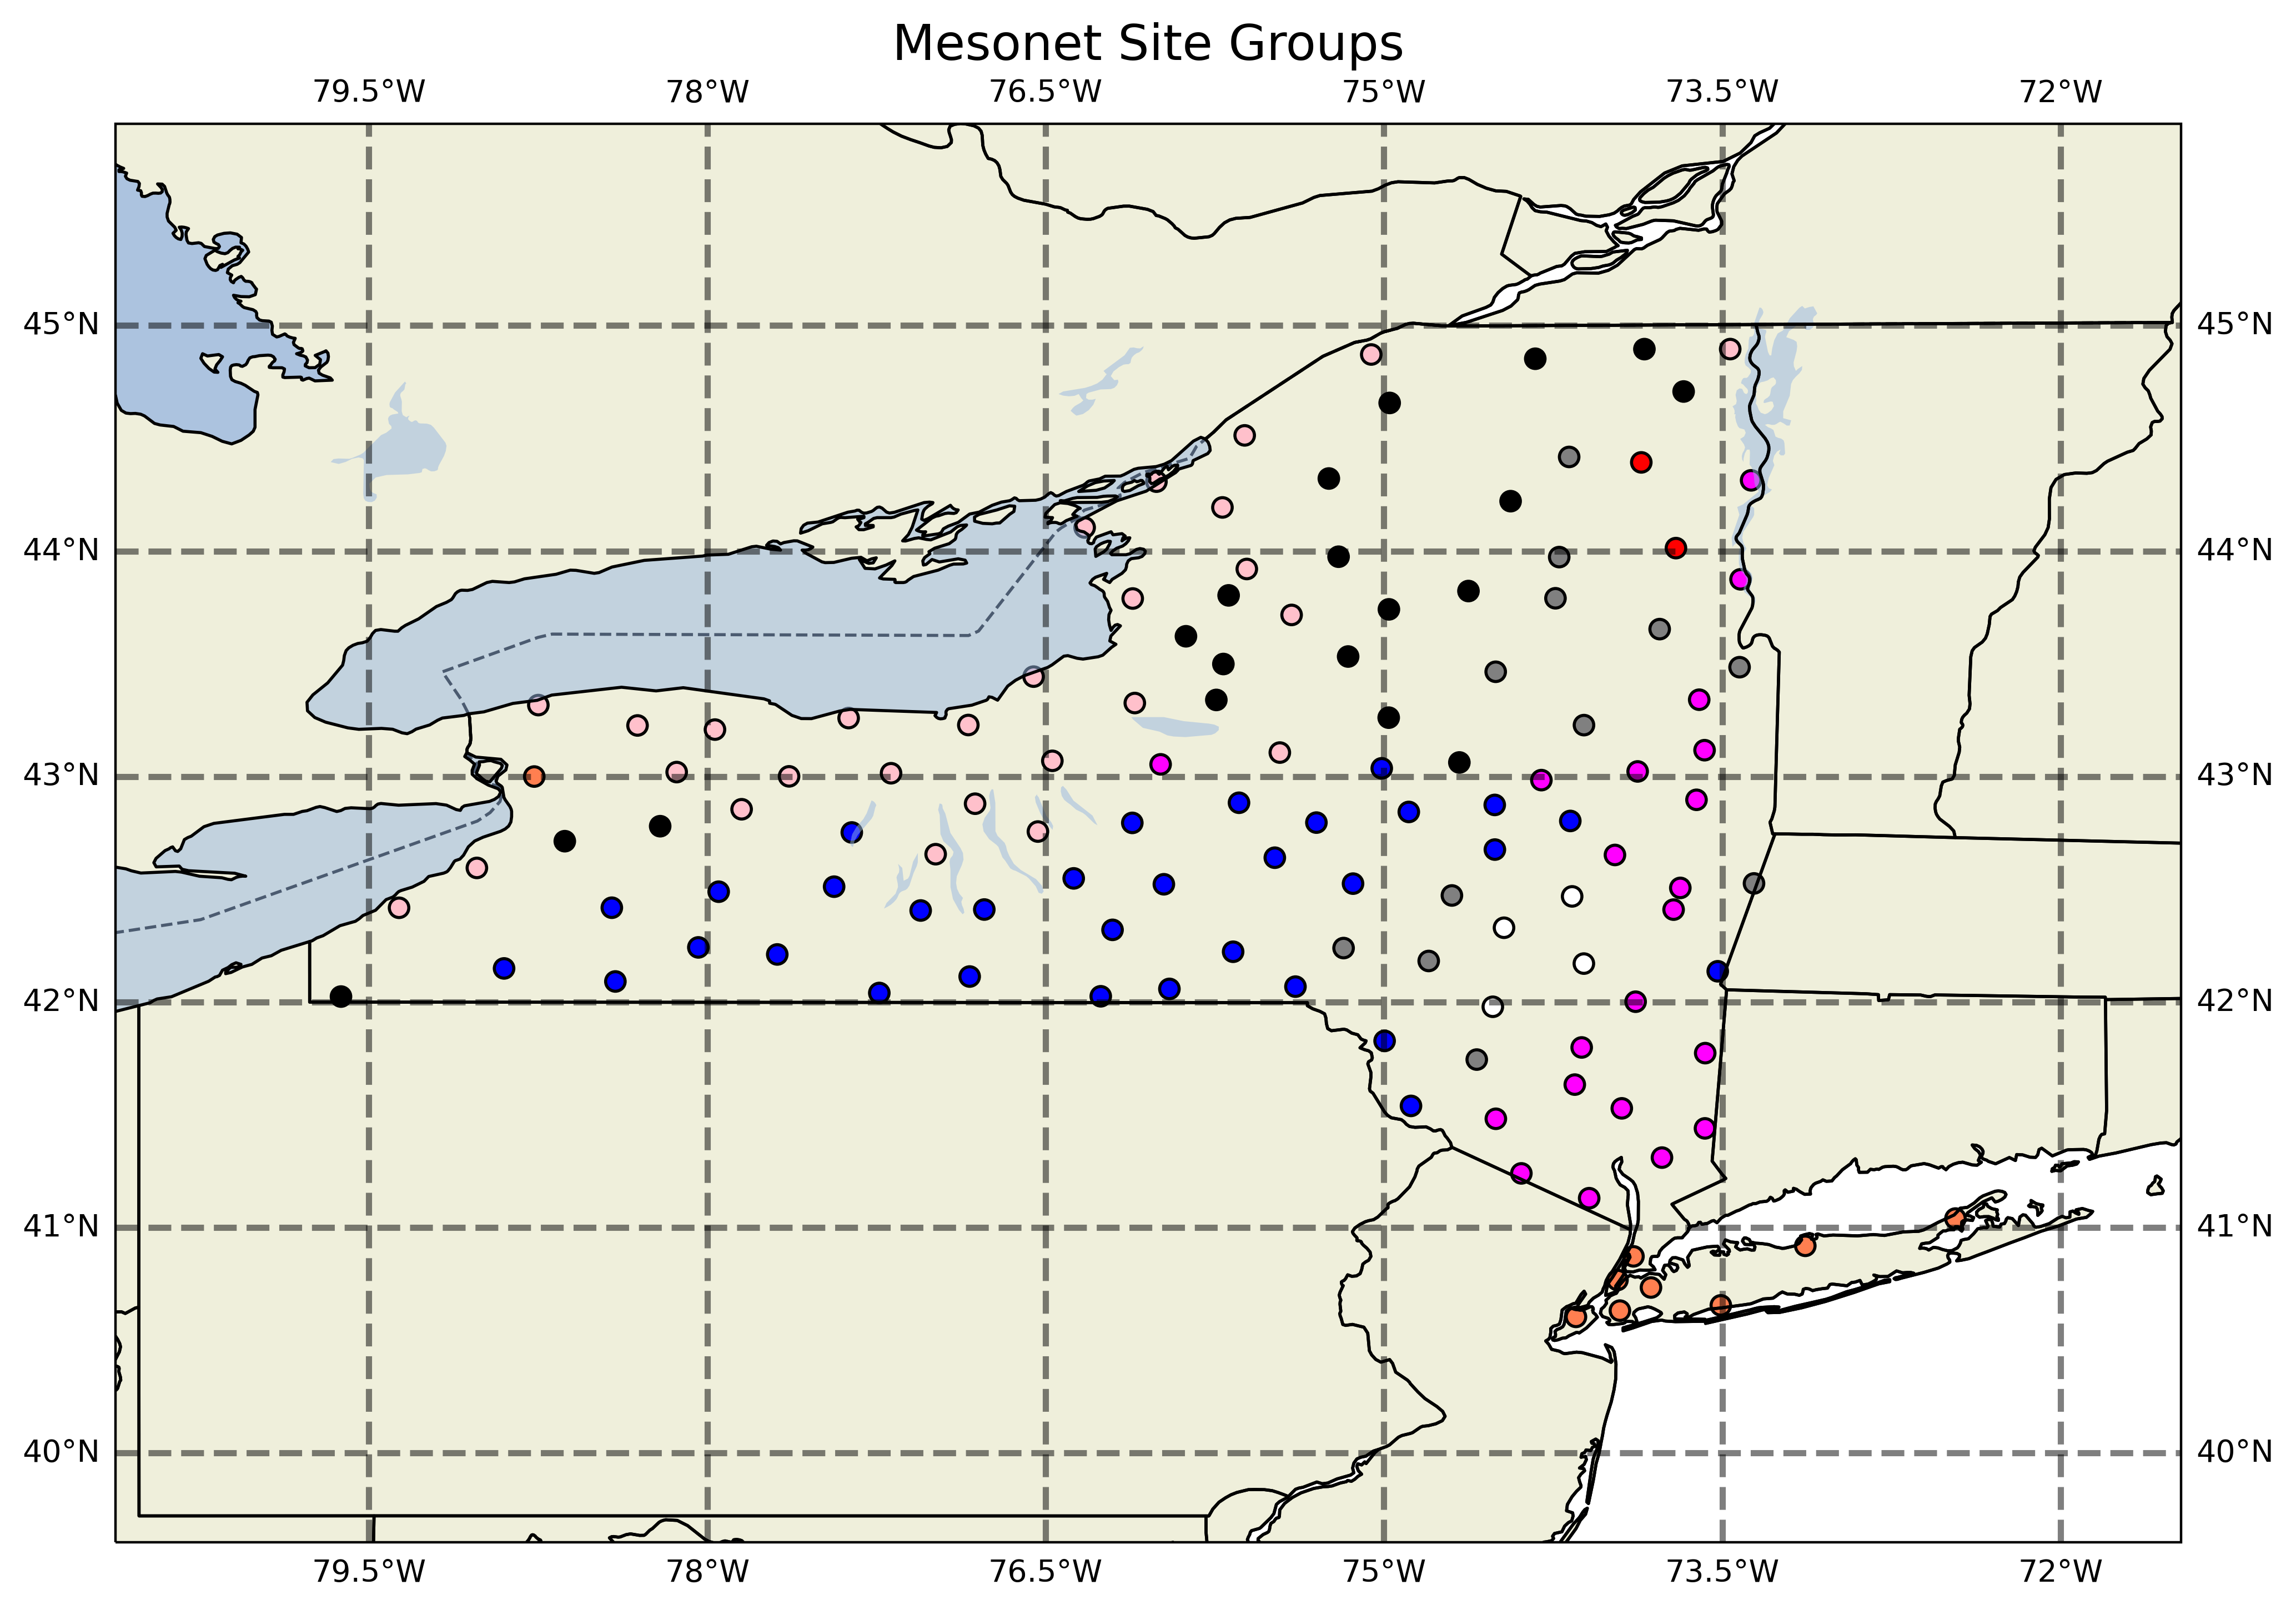

In [168]:
plurality_plot(sortAll)

In [169]:
sortAll.head()

,station,Cluster,lon,lat,color
0,ADDI,1,-77.237259,42.040359,blue
1,ANDE,7,-74.801392,42.182270,gray
2,BATA,4,-78.135658,43.019939,pink
3,BEAC,6,-73.945267,41.528751,magenta
4,BELD,1,-75.668518,42.223221,blue


In [172]:
sortAll.to_csv("/home/aevans/nwp_bias/src/landtype/data/ny_geo_clusters.csv")

In [170]:
for i in np.arange(0, 12):
    slopes_cat = sortAll.loc[sortAll["Cluster"] == i]
    slopes_cat = pd.merge(slopes_cat, comb_df, on="station")
    slopes_cat = pd.merge(slopes_cat, df_land, on="station")
    plurality_plot_x(slopes_cat)
# slopes_cat.to_csv(f'/home/aevans/landtype/data/clean_cats/ny/df_{i}.csv')

NameError: name 'df_land' is not defined

In [ ]:
df_a = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_0.csv")
df_a.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_a)

In [ ]:
# for n,_ in enumerate(df_a['station']):
#     if df_a['lon_x'].iloc[n] < -76:
#         df_a['Cluster'].iloc[n] = 6
#     if df_a['lat_x'].iloc[n] < 43:
#         if df_a['lon_x'].iloc[n] > -75:
#             df_a['Cluster'].iloc[n] = 7
#     if df_a['lat_x'].iloc[n] > 43:
#         df_a['Cluster'].iloc[n] = 8

In [ ]:
df_b = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_1.csv")
df_b.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_b)

In [ ]:
# for n,_ in enumerate(df_b['station']):
#     if df_b['lat_x'].iloc[n] < 43.3:
#         if df_b['lon_x'] > -75:
#             df_b['Cluster'].iloc[n] = 9

In [ ]:
df_c = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_2.csv")
df_c.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_c)

In [ ]:
# for n,_ in enumerate(df_c['station']):
#     if df_c['lat'].iloc[n] < 43:
#         df_c['Cluster'].iloc[n] = 9

In [ ]:
df_d = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_3.csv")
df_d.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_d)

In [ ]:
# for n,_ in enumerate(df_d['station']):
#     if df_d['lat'].iloc[n] < 42.6:
#         if df_d['lon'].iloc[n] > -75:
#             df_d['Cluster'].iloc[n] = 10
#         if df_d['lon'].iloc[n] < -78:
#             df_d['Cluster'].iloc[n] = 11
#     if df_d['lat'].iloc[n] >= 42.6:
#         if df_d['lon'].iloc[n] < -74.1:
#             if df_d['lat'].iloc[n] < 44:
#                 df_d['Cluster'].iloc[n] = 12

In [ ]:
df_e = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_4.csv")
df_e.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_e)

In [ ]:
# for n,_ in enumerate(df_e['station']):
#     if df_e['lon'].iloc[n] < -76:
#         df_e['Cluster'].iloc[n] = 13

In [ ]:
df_f = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_5.csv")
df_f.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_f)

In [ ]:
df_g = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_6.csv")
df_g.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_g)

In [ ]:
df_h = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_7.csv")
df_h.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_h)

In [ ]:
# df_i = pd.read_csv(f'/home/aevans/landtype/data/clean_cats/ny/df_8.csv')
# df_i.drop(columns = ['Unnamed: 0', 'site_x',
#        '11', '21_x', '22_x', '23_x', '24_x', '31_x', '41', '42', '43', '52',
#        '71', '81', '82', '90', '95', 'Unnamed: 0_x','site_y', '19', '21_y', '22_y',
#        '23_y', '24_y', '25', '26', '27', '28', '33', '37', '32', '34', '38',
#        '31_y', '35', '36', 'Unnamed: 0_y', 'sum_total' ])

In [ ]:
# plurality_plot_x(df_i)

In [ ]:
# df_j = pd.read_csv(f'/home/aevans/landtype/data/clean_cats/ny/df_9.csv')
# df_j.drop(columns = ['Unnamed: 0', 'site_x',
#        '11', '21_x', '22_x', '23_x', '24_x', '31_x', '41', '42', '43', '52',
#        '71', '81', '82', '90', '95', 'Unnamed: 0_x','site_y', '19', '21_y', '22_y',
#        '23_y', '24_y', '25', '26', '27', '28', '33', '37', '32', '34', '38',
#        '31_y', '35', '36', 'Unnamed: 0_y', 'sum_total' ])

In [ ]:
# plurality_plot_x(df_j)

In [ ]:
# df_new_cats = pd.concat([df_a, df_b, df_c, df_d, df_e, df_f, df_g, df_h])
# df_new_cats.to_csv('/home/aevans/landtype/df_new_cats.csv')

# Let's explain the clusters

In [ ]:
from kmeans_interp.kmeans_feature_imp import KMeansInterp

kms = KMeansInterp(
    n_clusters=len(sortAll["Cluster"].unique()),
    random_state=1,
    ordered_feature_names=features_all.keys(),
    feature_importance_method="wcss_min",
).fit(features_all)
labels = kms.labels_
sortAll["Cluster"] = labels

In [ ]:
centroids = kms.cluster_centers_
num_clusters = kms.n_clusters
n_features = kms.n_features_in_
centroids_labels = pd.DataFrame(
    {
        "centroid_dim": np.array(
            [centroids[i] for i in range(len(centroids))]
        ).flatten(),
        "cluster_label": np.array(
            [np.repeat(label, n_features) for label in range(num_clusters)]
        ).flatten(),
    }
)

In [ ]:
centroids_labels[centroids_labels["cluster_label"] == 0]["centroid_dim"]

In [ ]:
kms.feature_importances_[1][:-1]

In [ ]:
for cluster_label, feature_weights in kms.feature_importances_.items():
    df_feature_weight = pd.DataFrame(
        feature_weights[:15], columns=["Feature", "Weight"]
    )
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left")
    ax.tick_params(axis="both", which="major", labelsize=22)
    plt.title(
        f"Highest Weight Features in Cluster {cluster_label}", fontsize="xx-large"
    )
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Weight", fontsize=18)

    plt.show()

    print("\n\n")